In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import re


In [45]:
# Load the dataset
data = pd.read_csv("IMDB Dataset.csv")  # Replace with your dataset path
data.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [46]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', str(text))  # Remove punctuation
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove single characters
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)  # Remove single characters from the start
    text = re.sub(r'\s+', ' ', text, flags=re.I)  # Substitute multiple spaces with a single space
    text = re.sub(r'^b\s+', '', text)  # Remove prefixed 'b'
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

data['cleaned_review'] = data['review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['cleaned_review']).toarray()
y = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)  # Encode sentiment as binary


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [49]:
# Initialize the model
model = MultinomialNB()

# Train the model
model.fit(X_train, y_train)


MultinomialNB()

In [50]:
# Make predictions on the test set
y_pred = model.predict(X_test)


Accuracy: 0.8546666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      7411
           1       0.86      0.86      0.86      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



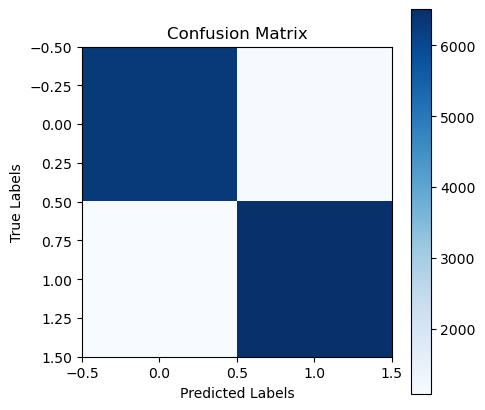

In [51]:
# Accuracy Score
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(conf_matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.show()


In [52]:
def predict_sentiment(review):
    review = preprocess_text(review)
    review_vector = tfidf.transform([review]).toarray()
    prediction = model.predict(review_vector)
    return "Positive" if prediction == 1 else "Negative"

# Test with a custom review
print(predict_sentiment("This movie was absolutely fantastic!"))


Positive


In [53]:
print(predict_sentiment("I just wasted my time"))

Negative


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predictions from the model
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.8546666666666667
Precision: 0.8553409538825384
Recall: 0.8578205297140599
F1-score: 0.8565789473684211
Confusion Matrix:
 [[6310 1101]
 [1079 6510]]


In [55]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
}

# Initialize GridSearchCV with Naive Bayes
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'alpha': 5.0}
Best Score: 0.8556000000000001


In [56]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)


MemoryError: Unable to allocate 20.9 GiB for an array with shape (35000, 5000) and data type <U32

In [ ]:
print(type(X_train))
print(X_train[:5])  # Show a few samples to check the format


In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

# Add PCA to the pipeline for dimensionality reduction
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=1000)),  # Limit vector size
    ('pca', PCA(n_components=100)),                      # Reduce dimensionality
    ('MultinomialNB', MultinomialNB())
])

param_distributions = {
    'vectorizer__max_features': [500, 1000],             # Test smaller vocab sizes
    'pca__n_components': [50, 100, 200],                 # Try different PCA components
    'classifier__C': [0.1, 1, 10]                        # Example classifier parameter
}

random_search = RandomizedSearchCV(pipeline, param_distributions, cv=3, n_iter=10, scoring='accuracy', n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
